# 1

Read the data file and plot the dataset.

In [1]:
import numpy as np

data=np.loadtxt('data.txt');

N, dim = data.shape

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

def plot_data():

    fig, ax = plt.subplots(figsize=(16, 10))
    
    ax.scatter(data[:,0], data[:,1])
    
    return fig, ax

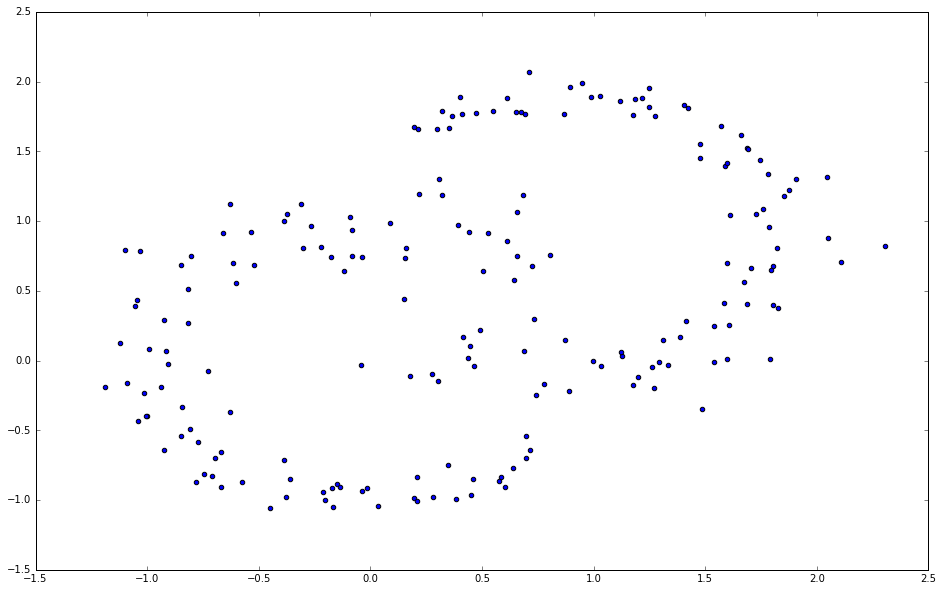

In [3]:
fig, ax = plot_data()

# 2 and 3

Find the 5 nearest neighbours and compose the weight and the Laplace matrix of the graph.

In [4]:
from sklearn.neighbors import NearestNeighbors

k=5
k = k+1 #knn algorithm counts the point itself too

nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
distances, indices = nbrs.kneighbors(data)

#Ignore points itself
distances = distances[:,1:] 
indices = indices[:,1:]

A = nbrs.kneighbors_graph(data).toarray()
A = np.logical_or(A, A.transpose()) #Make it undirected

#(A.transpose() == A).all() #Check if A is symmetric

# Calculate euclidean distances
W = nbrs.kneighbors_graph(data, mode='distance').toarray()

sig = 0.3
W = np.exp(-0.5* np.square(W/sig))

D = W.sum(axis=0)
T = W / D
#T = T * D[:, np.newaxis]
L = np.eye(N) - T

Plot the k-nearest graph.

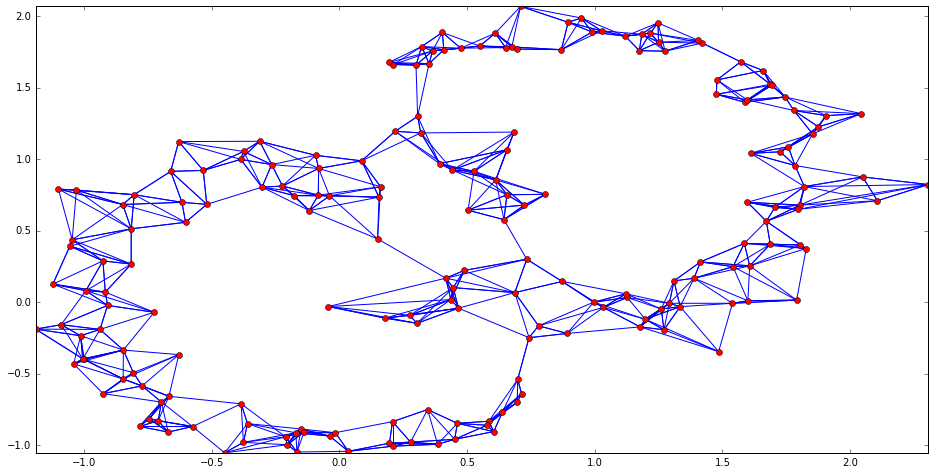

In [5]:
from matplotlib.collections import LineCollection

edges = []
for i in range(N):
    edges = edges + [[i,x] for x in indices[i,:]]

#print(edges)

lc = LineCollection(data[edges])
fig = plt.figure(figsize=(16,8))
plt.gca().add_collection(lc)
plt.xlim(data[:,0].min(), data[:,0].max())
plt.ylim(data[:,1].min(), data[:,1].max())
plt.plot(data[:,0], data[:,1], 'ro');

# 4

My idea is to use the simultaneous iteration to find the 2 smallest eigenvalues and eigenvectors. I used the idea of the inverse pwoer iteration method. In order to find the 2 smallest eigenvalues of $L$, I calculated the 2 largest eigenvalues of $(L-\mu \times I)^{-1}$, which have the same eigenvectors and reciprocal eigenvalues shifted by $\mu$. 

When we start the iteration with two orthogonal vectors and apply the simulatenous iteration, these two vectors are expected to converge to the 2 eigenvectors whose corresponding eigenvalues are the 2 largest eigenvalues.

At the end of the iteration, I calculate the corresponding eigenvalues with the Rayleigh quotient.

In [6]:
from scipy import linalg as la

N_iter = 100

# Generate random 2 orthogonal columns
J = np.random.rand(N,2)
Q, R = np.linalg.qr(J, mode='reduced')

#Spectral shift for the inverse power iteration
mu = 0.000001
M = L - np.eye(N)*mu

for k in range(N_iter):
    Z = np.linalg.solve(M, Q)
    Q, R = np.linalg.qr(Z, mode='reduced')

#v is the second largest eigenvector of inv(L), thus, the second smallest eigenvector of L.
v = Q[:,1]
    
EV0 = np.dot(np.dot(Q[:,0].transpose(), L), Q[:,0]) #The smallest eigenvalue of L
EV1 = np.dot(np.dot(v.transpose(), L), v) #The 2nd smallest eignvalue of L

In [7]:
#a = Q[:,0]
#np.allclose(np.linalg.solve(L, a), a/EV0)
#np.diag((EV0, EV1))
#np.allclose(np.dot(L,a), a*EV0)

In [8]:
print(EV0)
print(EV1)

print(1/(EV0-mu))
print(1/(EV1-mu))

9.10560418298e-18
0.999210875681
-1000000.00001
1.00079074911


# 5

I expected to see a seperated hill shape in the histogram. However I could not see why it does not. I could not see anything wrong in my idea. 

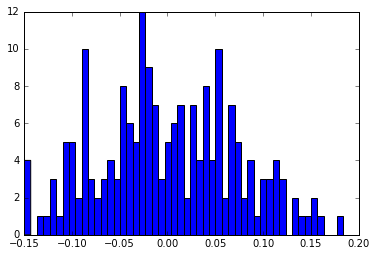

In [9]:
plt.hist(v, bins=50);

# 6

Clustering result.

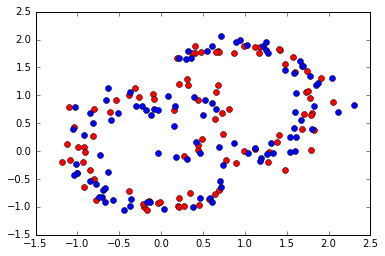

In [10]:
tau = 0.0

clusters = v>tau

plt.plot(data[np.where(clusters),0], data[np.where(clusters),1], 'ro');
plt.plot(data[np.where(np.logical_not(clusters)),0], data[np.where(np.logical_not(clusters)),1], 'bo');